<img src="https://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# Reinforcement Learning for Finance

**Chapter 09 &mdash; Optimal Execution**

&copy; Dr. Yves J. Hilpisch

<a href="https://tpq.io" target="_blank">https://tpq.io</a> | <a href="https://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:team@tpq.io">team@tpq.io</a>

## Model Implementation

In [1]:
!git clone https://github.com/tpq-classes/rl_4_finance.git
import sys
sys.path.append('rl_4_finance')


Cloning into 'rl_4_finance'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (75/75), done.
Receiving objects: 100% (111/111), 162.65 KiB | 1.71 MiB/s, done.
remote: Total 111 (delta 71), reused 56 (delta 36), pack-reused 0 (from 0)
Resolving deltas: 100% (71/71), done.


In [2]:
import math
import random
import numpy as np
import pandas as pd
from pylab import plt, mpl

In [3]:
plt.style.use('seaborn-v0_8')
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
np.set_printoptions(suppress=True)

In [4]:
class AlmgrenChriss:
    def __init__(self, T, N, S0, sigma, X, eta, gamma, lamb):
        self.T = T
        self.N = N
        self.dt = T / N
        self.S0 = S0
        self.sigma = sigma
        self.X = X
        self.eta = eta
        self.gamma = gamma
        self.lamb = lamb

In [5]:
class AlmgrenChriss(AlmgrenChriss):
    def optimal_execution(self):
        kappa = np.sqrt(self.lamb * self.sigma ** 2 / self.gamma)
        t = np.linspace(0, self.T, self.N + 1)
        xt_sum = self.X * np.sinh(kappa * (self.T - t)) / np.sinh(kappa * self.T)
        xt = -np.diff(xt_sum, prepend=0)
        xt[0] = 0
        return t, xt

In [6]:
T = 10  # <1>
N = 10  # <2>
S0 = 1  # <3>
sigma = 0.15  # <4>
X = 1  # <5>
eta = 0.1  # <6>
gamma = 0.1  # <7>
lamb = 3e-1  # <8>

In [7]:
ac = AlmgrenChriss(T, N, S0, sigma, X, eta, gamma, lamb)

In [8]:
t, xt = ac.optimal_execution()

In [9]:
t

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [10]:
xt.round(2)  # <9>

array([0.  , 0.23, 0.18, 0.14, 0.11, 0.09, 0.07, 0.06, 0.05, 0.04, 0.04])

In [11]:
xt.sum()

np.float64(1.0)

In [12]:
ac.lamb = 1e-4  # <10>

In [13]:
t, xt_ = ac.optimal_execution()
xt_.round(2)  # <11>

array([0. , 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

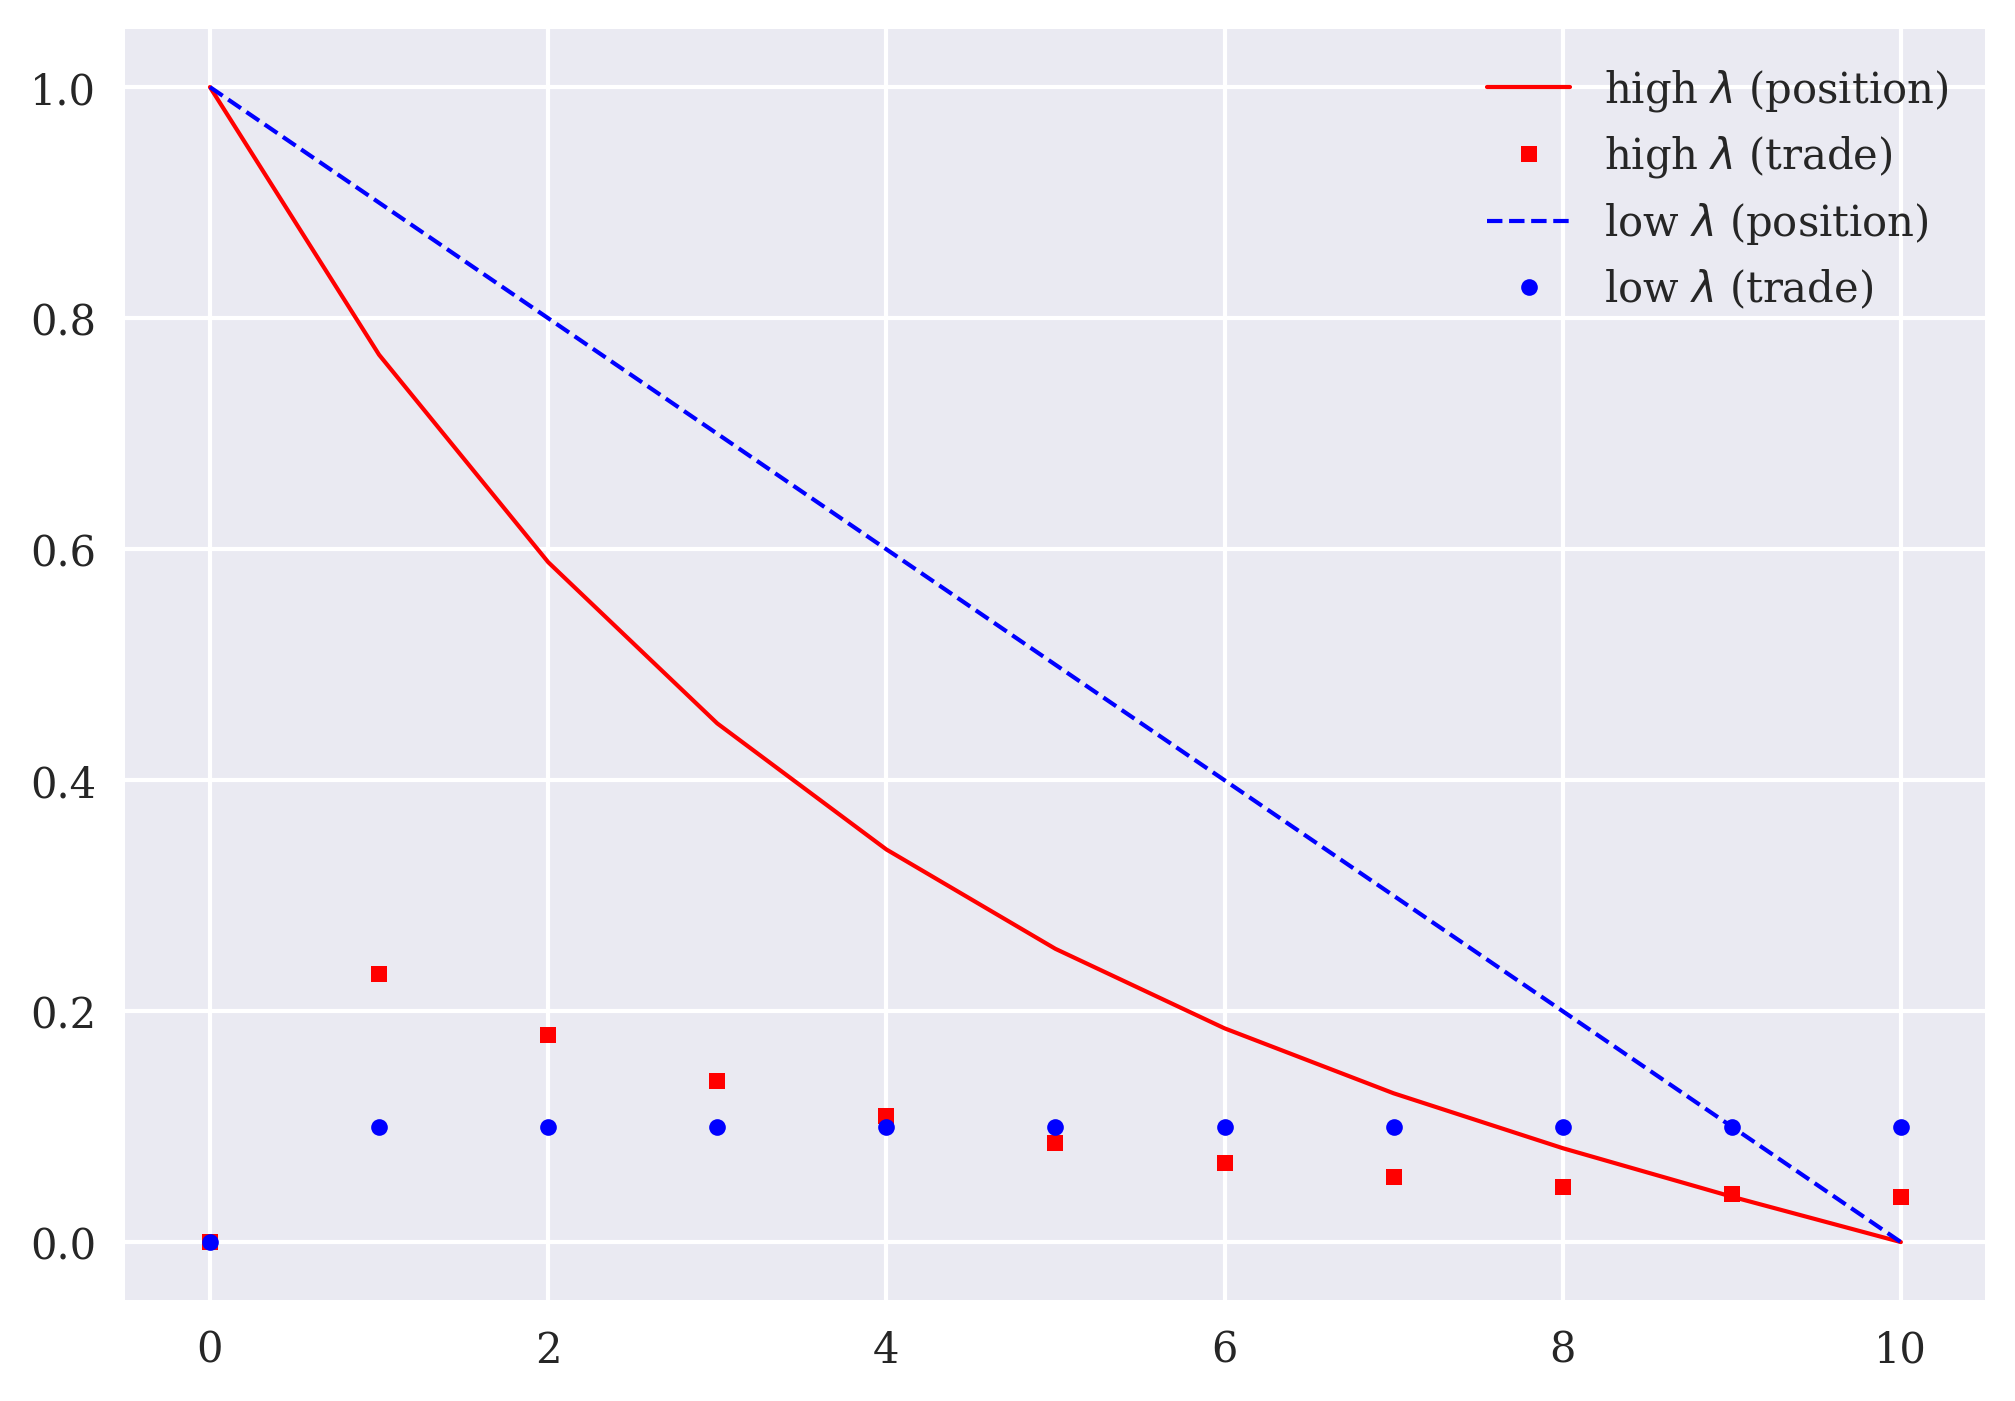

In [14]:
plt.plot(t, ac.X - xt.cumsum(), 'r', lw=1,
         label='high $\\lambda$ (position)')
plt.plot(t, xt, 'rs', markersize=4,
         label='high $\\lambda$ (trade)')
plt.plot(t, ac.X- xt_.cumsum(), 'b--', lw=1,
         label='low $\\lambda$ (position)')
plt.plot(t, xt_, 'bo', markersize=4,
         label='low $\\lambda$ (trade)')
plt.legend();

In [15]:
from numpy.random import default_rng

In [16]:
class AlmgrenChriss(AlmgrenChriss):
    def simulate_stock_price(self, xt, seed=None):
        rng = default_rng(seed=seed)
        S = np.zeros(self.N + 1)  # <1>
        S[0] = self.S0  # <1>
        P = np.zeros(self.N + 1)  # <2>
        P[0] = self.S0  # <2>
        for t in range(1, self.N + 1):
            dZ = rng.normal(0, np.sqrt(self.dt))
            S[t] = S[t - 1] + sigma * dZ  # <1>
            P[t] = S[t] - self.eta * xt[:t + 1].sum()  # <2>
        return S, P

In [17]:
ac = AlmgrenChriss(T, N, S0, sigma, X, eta, gamma, lamb)

In [18]:
t, xt = ac.optimal_execution()

In [19]:
xt.round(2)

array([0.  , 0.23, 0.18, 0.14, 0.11, 0.09, 0.07, 0.06, 0.05, 0.04, 0.04])

In [20]:
seed = 250

In [21]:
S, P = ac.simulate_stock_price(xt, seed=seed)

In [22]:
ac.lamb = 1e-4

In [23]:
t, xt_ = ac.optimal_execution()

In [24]:
xt_.round(2)

array([0. , 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [25]:
S, P_ = ac.simulate_stock_price(xt_, seed=seed)

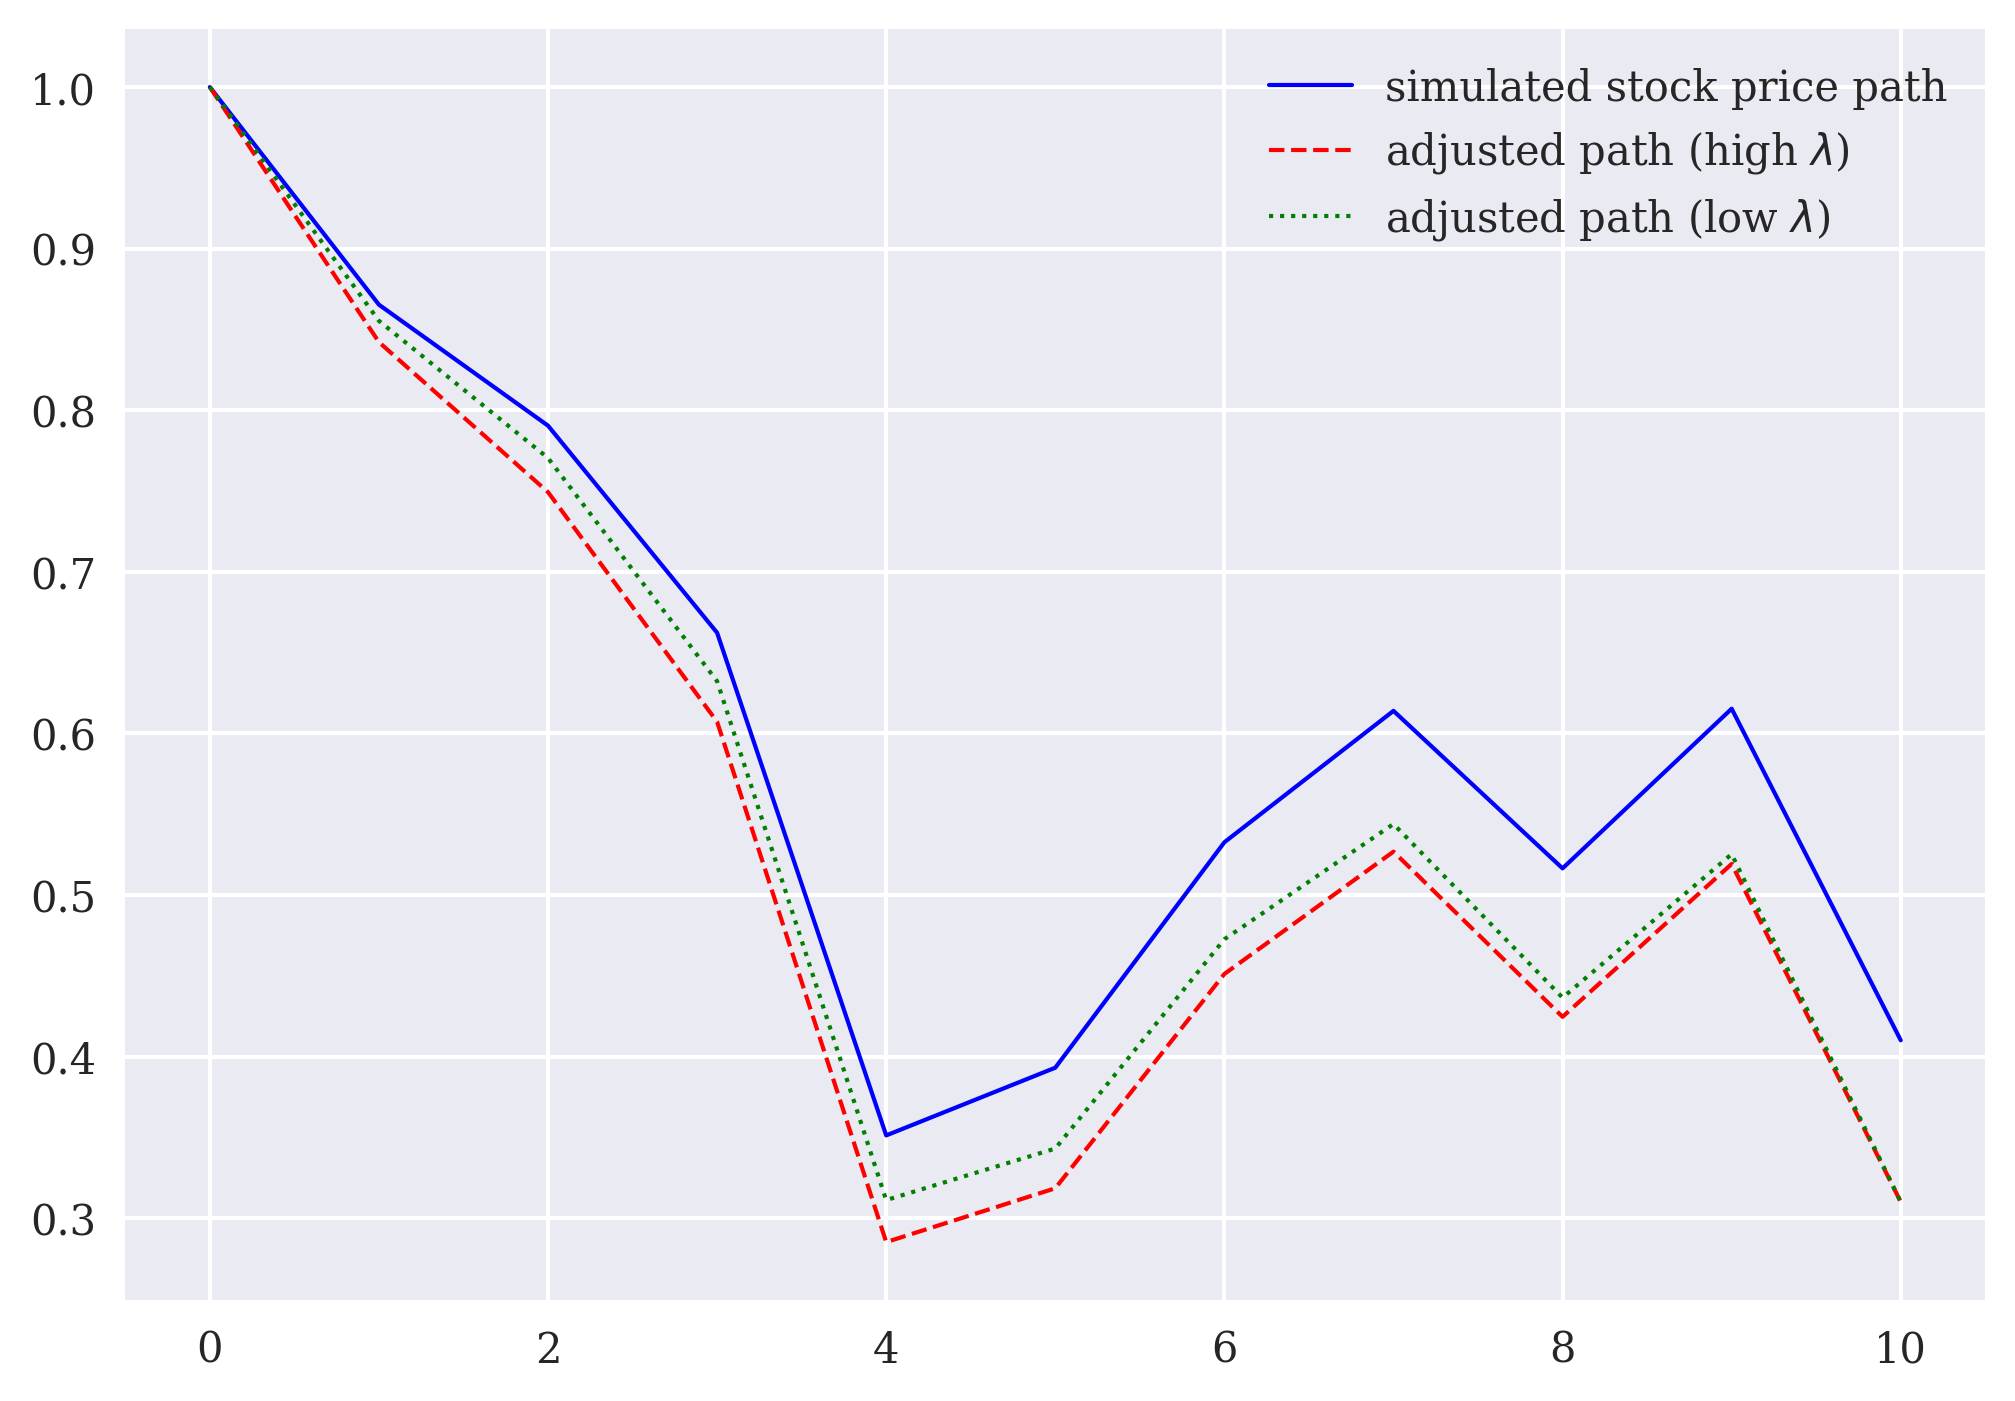

In [26]:
plt.plot(t, S, 'b', lw=1, label='simulated stock price path')
plt.plot(t, P, 'r--', lw=1, label='adjusted path (high $\\lambda$)');
plt.plot(t, P_, 'g:', lw=1, label='adjusted path (low $\\lambda$)')
plt.legend();

In [27]:
class AlmgrenChriss(AlmgrenChriss):
    def calculate_costs(self, xt):
        temporary_cost = np.sum(self.gamma * (xt / self.dt) ** 2 * self.dt)
        permanent_cost = np.sum(self.eta * np.cumsum(xt) * xt)
        execution_risk = self.lamb * self.sigma ** 2 * np.sum(
            (np.cumsum(xt[::-1])[::-1] / self.dt) ** 2 * self.dt)
        TEC = temporary_cost + permanent_cost + execution_risk
        return temporary_cost, permanent_cost, execution_risk, TEC

In [28]:
ac = AlmgrenChriss(T, N, S0, sigma, X, eta, gamma, lamb)

In [29]:
t, xt = ac.optimal_execution()

In [30]:
tc, pc, er, TEC = ac.calculate_costs(xt)

In [31]:
print(f'lambda = {ac.lamb}')
print(f'temporary cost = {tc:7.4f}')
print(f'permanent cost = {pc:7.4f}')
print(f'execution risk = {er:7.4f}')
print(f'total ex. cost = {TEC:7.4f}')  # <1>

lambda = 0.3
temporary cost =  0.0138
permanent cost =  0.0569
execution risk =  0.0228
total ex. cost =  0.0935


In [32]:
ac.lamb = 1e-4

In [33]:
t, xt_ = ac.optimal_execution()

In [34]:
tc, pc, er, TEC = ac.calculate_costs(xt_)

In [35]:
print(f'lambda = {ac.lamb}')
print(f'temporary cost = {tc:7.4f}')
print(f'permanent cost = {pc:7.4f}')
print(f'execution risk = {er:7.4f}')
print(f'total ex. cost = {TEC:7.4f}')  # <2>

lambda = 0.0001
temporary cost =  0.0100
permanent cost =  0.0550
execution risk =  0.0000
total ex. cost =  0.0650


## Execution Environment

In [36]:
class observation_space:
    def __init__(self, n):
        self.shape = (n,)

In [37]:
class action_space:
    def __init__(self, n):
        self.n = n
    def seed(self, seed):
        random.seed(seed)
    def sample(self):
        return random.random()  # <1>

In [38]:
class Execution:
    def __init__(self, T, N, S0, sigma, X, eta, gamma, lamb):
        self.T = T
        self.N = N
        self.dt = T / N
        self.S0 = S0
        self.sigma = sigma
        self.X = X
        self.eta = eta
        self.gamma = gamma
        self.lamb = lamb
        self.episode = 0
        self.observation_space = observation_space(3)
        self.osn = self.observation_space.shape[0]
        self.action_space = action_space(1)

In [39]:
class Execution(Execution):
    def _simulate_data(self, seed=None):
        self.dt = T / N
        if hasattr(self, 'seed_'):
            seed = self.seed_
        rng = default_rng(seed=seed)
        self.S = np.zeros(self.N + 1)
        self.S[0] = self.S0
        for t in range(1, self.N + 1):
            dZ = rng.normal(0, np.sqrt(self.dt))
            self.S[t] = self.S[t - 1] + self.sigma * dZ
        return self.S

In [40]:
class Execution(Execution):
    def _get_state(self):
        # St = self.S[self.bar]
        # Pt = self.S[self.bar] - self.eta * self.xt.sum()
        return np.array([self.X_,
                         self.bar / self.N,
                         self.x]), {}
    def seed(self, seed=None):
        self.seed = seed
    def reset(self):
        self.bar = 0
        self.x = 0
        self.x_ = 0
        self.treward = 0
        self.episode += 1
        self.X_ = self.X
        self.xt = np.zeros(self.N + 1)
        self.tec = pd.DataFrame(
            {'pc': 0, 'tc': 0, 'er': 0}, index=[0])
        self._simulate_data()
        self.state, _ = self._get_state()
        return self.state, _

In [41]:
class Execution(Execution):
    def step(self, action):
        self.bar += 1
        self.xt[self.bar] = action
        self.x_ = self.x
        self.x = action
        self.X_ -= action
        pc = np.sum(self.eta * np.cumsum(self.xt) * self.xt)
        tc = np.sum(self.gamma * (self.xt / self.dt) ** 2 * self.dt)
        er = self.lamb * self.sigma ** 2 * np.sum(
            (np.cumsum(self.xt[::-1])[::-1] / self.dt) ** 2 * self.dt)
        df = pd.DataFrame({'pc': tc, 'tc': pc, 'er': er}, index=[0])
        self.tec = pd.concat((self.tec, df))
        tec = self.tec.diff().fillna(0).iloc[-1]
        cost = tec.sum()
        self.state, _ = self._get_state()
        pen = 0
        reward = 0
        if self.bar < self.N:
            if self.X_ < 0.05:
                done = False  # if True it might stop early (before N is reached)
            else:
                #pen = abs(self.x - self.x_)
                #reward = self.x
                done = False
        elif self.bar == self.N:
            pen = abs(self.X_)
            done = True
        return self.state, reward-(cost+pen), done, False, {}

In [42]:
execution = Execution(T, N, S0, sigma, X, eta, gamma, lamb=1e-4)

In [43]:
execution.reset()
execution.step(1.0)

(array([0. , 0.1, 1. ]), np.float64(-0.2000045), False, False, {})

In [44]:
execution.reset()

(array([1., 0., 0.]), {})

In [45]:
execution.step(0.5)

(array([0.5, 0.1, 0.5]), np.float64(-0.050001125), False, False, {})

In [46]:
execution.step(0.5)

(array([0. , 0.2, 0.5]), np.float64(-0.0750039375), False, False, {})

In [47]:
execution.reset()
for i in range(10):
    execution.step(0.1)
-execution.tec.diff().sum().sum()

np.float64(-0.06501091250000002)

## Random Agent

In [48]:
execution = Execution(T, N, S0, sigma, X, eta, gamma, lamb=1e-4)

In [49]:
def gen_rn():
    alpha = np.ones(N)
    rn = np.random.dirichlet(alpha)
    rn = np.insert(rn, 0, 0)
    return rn

In [50]:
rn = gen_rn()
rn

array([0.        , 0.0327626 , 0.01814423, 0.13033093, 0.18578899,
       0.03798787, 0.00586602, 0.13217823, 0.31790418, 0.06524516,
       0.07379177])

In [51]:
rn.sum()

np.float64(1.0000000000000002)

In [52]:
for _ in range(5):
    execution.reset()
    rn = gen_rn()
    print(rn.round(3))
    for i in range(1, 11):
        execution.step(rn[i])
    print(execution.tec.diff().sum().sum())
    print()

[0.    0.037 0.065 0.    0.002 0.034 0.233 0.273 0.096 0.169 0.09 ]
0.0772561053685287

[0.    0.056 0.021 0.081 0.107 0.057 0.08  0.127 0.218 0.251 0.001]
0.07369807354983096

[0.    0.05  0.146 0.015 0.074 0.117 0.015 0.267 0.086 0.039 0.191]
0.0740391336325205

[0.    0.009 0.284 0.03  0.    0.157 0.029 0.11  0.121 0.151 0.109]
0.07529875006192054

[0.    0.141 0.069 0.008 0.026 0.05  0.019 0.131 0.197 0.356 0.003]
0.08162169768108059



In [53]:
execution = Execution(T, N, S0, sigma, X, eta, gamma, lamb=lamb)

In [54]:
for _ in range(5):
    execution.reset()
    rn = gen_rn()
    print(rn.round(3))
    for i in range(1, 11):
        execution.step(rn[i])
    print(execution.tec.iloc[-1].sum())
    print()

[0.    0.314 0.031 0.049 0.221 0.003 0.054 0.194 0.023 0.033 0.079]
0.10489210519481981

[0.    0.199 0.002 0.138 0.206 0.039 0.058 0.113 0.012 0.224 0.008]
0.10465158083562044

[0.    0.172 0.231 0.02  0.105 0.02  0.003 0.034 0.042 0.369 0.004]
0.114219314088646

[0.    0.13  0.113 0.157 0.02  0.113 0.193 0.051 0.019 0.016 0.188]
0.10150251910173956

[0.    0.137 0.026 0.183 0.101 0.024 0.01  0.13  0.052 0.159 0.179]
0.10502528576848465



## Execution Agent

**_THIS IS WORK IN PROGRESS._**

In [55]:
import os
import warnings
warnings.simplefilter('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [56]:
from dqlagent import *

In [57]:
# random.seed(100)
# tf.random.set_seed(100)

In [67]:
opt = tf.keras.optimizers.Adam

In [68]:
class ExecutionAgent(DQLAgent):
    def _create_model(self, hu, lr):
        self.model = Sequential()
        self.model.add(Dense(hu, input_dim=self.n_features,
                        activation='relu'))
        self.model.add(Dense(hu, activation='relu'))
        self.model.add(Dense(1, activation='linear'))
        self.model.compile(loss='mse',
                optimizer=opt(learning_rate=lr))

In [69]:
from scipy.optimize import minimize

In [70]:
class ExecutionAgent(ExecutionAgent):
    def opt_action(self, state):
        bnds = [(0, state[0, 0])]
        def f(state, x):
            s = np.copy(state)
            s[0, 2] = x
            return self.model(tf.convert_to_tensor(s, dtype=tf.float32), training=False).numpy()[0, 0]
        action = minimize(lambda x: -f(state, x),
                          state[0, 0] / 2,
                          bounds=bnds,
                          method='Powell'
                         )['x'][0]
        return action

    def act(self, state):
        if random.random() <= self.epsilon or self.episodes < 250:
            return min(self.rn[self.f], state[0, 0])
        else:
            return self.opt_action(state)

In [71]:
class ExecutionAgent(ExecutionAgent):
    def replay(self):
        batch = random.sample(self.memory, self.batch_size)
        for state, action, next_state, reward, done in batch:
            if not done:
                action = self.opt_action(next_state)
                ns = np.copy(next_state)
                ns[0, 2] = action
                reward = (self.gamma *
                    self.model(tf.convert_to_tensor(ns, dtype=tf.float32), training=False).numpy()[0, 0])
            reward = np.array([reward])
            self.model.fit(state, reward, epochs=1,
                           verbose=False)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [72]:
class ExecutionAgent(ExecutionAgent):
    def learn(self, episodes):
        for e in range(1, episodes + 1):
            self.episodes += 1
            state, _ = self.env.reset()
            state = self._reshape(state)
            treward = 0
            alpha = np.ones(self.env.N)
            rn = np.random.dirichlet(alpha)
            self.rn = np.insert(rn, 0, 0)
            for f in range(1, 5000):
                self.f = f
                action = self.act(state)
                next_state, reward, done, trunc, _ = self.env.step(action)
                treward += reward
                next_state = self._reshape(next_state)
                self.memory.append(
                    [state, action, next_state, reward, done])
                state = next_state
                if done:
                    self.trewards.append(treward)
                    self.max_treward = max(self.max_treward, treward)
                    templ = f'episode={self.episodes:4d} | '
                    templ += f'treward={treward:7.3f}'
                    templ += f' | max={self.max_treward:7.3f}'
                    print(templ, end='\r')
                    break
            if len(self.memory) > self.batch_size:
                self.replay()
        print()

In [73]:
class ExecutionAgent(ExecutionAgent):
    def test(self, episodes, verbose=True):
        for e in range(1, episodes + 1):
            state, _ = self.env.reset()
            state = self._reshape(state)
            treward = 0
            for _ in range(1, self.env.N + 1):
                action = self.opt_action(state)
                state, reward, done, trunc, _ = self.env.step(action)
                state = self._reshape(state)
                treward += reward
                if done:
                    templ = f'total reward={treward:4.3f}'
                    if verbose:
                        print(templ)
                    break
            print(self.env.xt)

In [74]:
execution = Execution(T, N, S0, sigma, X, eta, gamma, lamb=1e-4)

In [75]:
executionagent = ExecutionAgent(None, feature=None, n_features=3,
                     env=execution, hu=24, lr=0.0001)

In [76]:
executionagent.gamma = 0.99

In [77]:
executionagent.epsilon_decay = 0.999

In [80]:
episodes = 10 # 100

In [81]:
%time executionagent.learn(episodes)


CPU times: user 5min 18s, sys: 1.7 s, total: 5min 20s
Wall time: 5min 23s


In [82]:
execution.xt

array([0.        , 0.08702953, 0.08725161, 0.20028094, 0.16989389,
       0.1610533 , 0.03734745, 0.0734962 , 0.01309053, 0.08990697,
       0.08064957])

In [83]:
execution.xt.sum()

np.float64(1.0)

In [84]:
executionagent.test(1)

total reward=-0.099
[0.         0.04660639 0.00000128 0.45056412 0.04127127 0.26379991
 0.09488148 0.09734271 0.00000009 0.00000095 0.00000068]


In [85]:
execution.xt.sum()

np.float64(0.9944688823626744)

In [86]:
len(executionagent.memory)

1080

<img src="https://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="https://tpq.io" target="_blank">https://tpq.io</a> | <a href="https://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:team@tpq.io">team@tpq.io</a>